# EVALUATION NOTEBOOK

#### Study on the effect of Prefilters
The dataset was transcribed with two different prefilters.
paired differences of the f-scores are shown as violinplot and boxplots

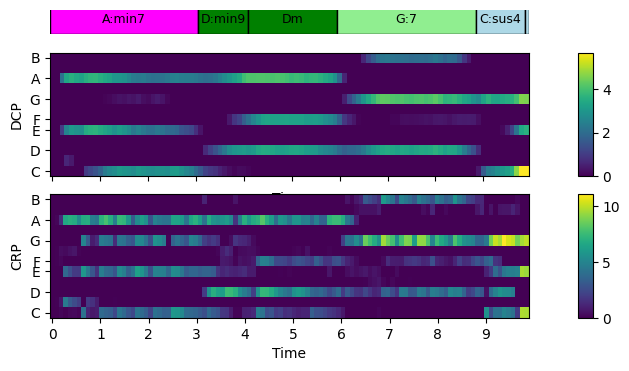

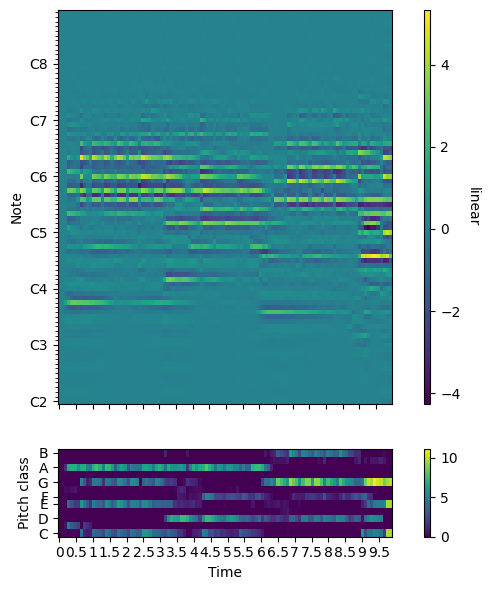

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa
import utils
import dataloader
import features
import mir_eval

dataset = dataloader.Dataloader("beatles",base_path="mirdata",source_separation="none")
audiopath,gtpath = dataset["1109"] # 0108 love me do, 1201 two of us

time_interval = (0,10)
y = utils.loadAudiofile(audiopath,duration=time_interval[1])
ref_intervals,ref_labels = utils.loadChordAnnotations(gtpath,time_interval)
# compute chromagram
estimated_tuning = librosa.estimate_tuning(y=y,sr=22050,bins_per_octave=36)
C = np.abs(librosa.vqt(y,fmin=librosa.midi_to_hz(36),filter_scale=1,
                    bins_per_octave=36,n_bins=36*5,
                    hop_length=512, sr=22050, tuning=estimated_tuning,gamma=0))
deepchroma = features.deepChroma(audiopath)
chroma = librosa.feature.chroma_cqt(y=y,hop_length=2048,sr=22050)
crp, pitchgram,pitchgram_cqt = features.crpChroma(y,nCRP=33,eta=100,liftering=True,window=True)


fig,ax = plt.subplots(3,2,figsize=(7,4),height_ratios=(1,5,5),width_ratios=(10,0.3))
utils.plotChordAnnotations(ax[0,0],ref_intervals,ref_labels)
img = utils.plotChromagram(ax[1,0],utils.timeVector(deepchroma.shape[1],hop_length=2205),deepchroma,time_interval,cmap="viridis")
plt.colorbar(img,cax=ax[1,1])
img = utils.plotChromagram(ax[2,0],utils.timeVector(crp.shape[1],hop_length=2048),crp,time_interval,cmap="viridis")
plt.colorbar(img,cax=ax[2,1])
ax[1,0].set_ylabel("DCP")
ax[1,0].set_xticklabels([])
ax[2,0].set_ylabel("CRP")
ax[0,0].set_axis_off()
ax[0,1].set_axis_off()
fig.savefig("../Präsentation/figures/crp_dcp.png")

t_chroma = utils.timeVector(N=chroma.shape[1],hop_length=2048)
fig,((ax1,ax11),(ax2,ax22)) = plt.subplots(2,2,width_ratios=(10,.2),height_ratios=(9,2),figsize=(5,6))
img = librosa.display.specshow(pitchgram,ax=ax1,hop_length=2048,bins_per_octave=12,
                         sr=22050,fmin=librosa.midi_to_hz(36),y_axis="cqt_note",
                        cmap="viridis",x_axis="s")
cbar = fig.colorbar(img,cax=ax11)
cbar.ax.set_ylabel("linear", rotation=-90, va="bottom")
img = utils.plotChromagram(ax2,t_chroma,crp,cmap="viridis")
fig.tight_layout(h_pad=0,w_pad=0)
cbar = fig.colorbar(img,cax=ax22)#
# fig.savefig("../Präsentation/figures/chromagram_crp.png")

ax1.set_xlabel("")
ax1.set_xticklabels([])
for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(0,time_interval[1],0.5));



majmin: wcsr=0.95,Q=0.77
sevenths: wcsr=0.21,Q=0.77


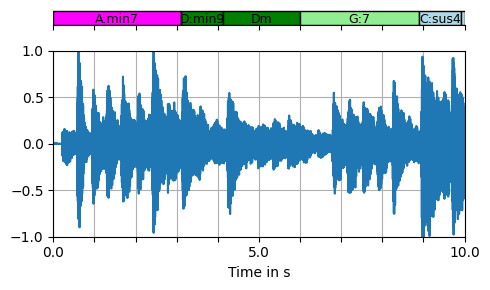

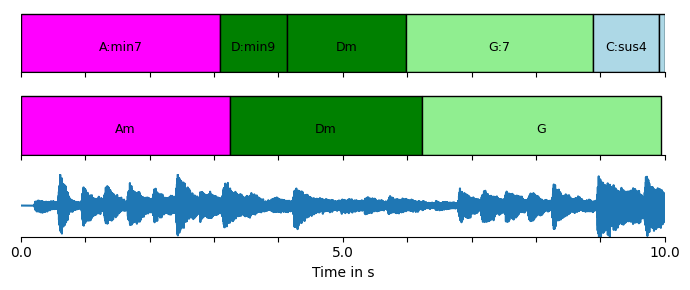

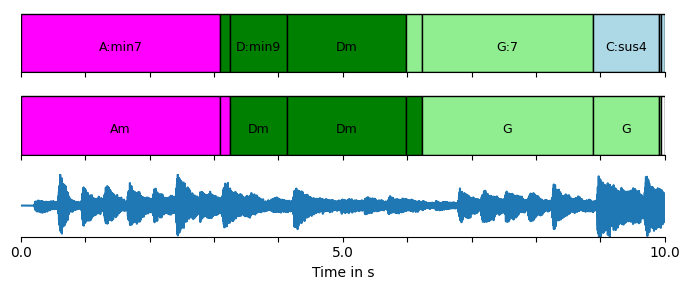

In [37]:

fig,(ax1,ax2) = plt.subplots(2,height_ratios=(.5,6),
                                                                 figsize=(5,3))
utils.plotChordAnnotations(ax1,ref_intervals,ref_labels,time_interval=time_interval,y_0=0)
ax1.set_ylim(0,1.5)
ax1.set_yticks([])
# Hide the y-axis line
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.axis("on")
ax2.plot(utils.timeVector(y.shape[0],hop_length=1),y)
ax2.set_xlim(0,10)
ax2.set_ylim(-1,1)
ax2.grid()
xticks = np.linspace(time_interval[0],time_interval[1],11)
xticklabels = [xticks[i] if i % 5 == 0 else "" for i in range(11)]
ax1.set_xticks(xticks)
ax1.set_xlabel("")
ax1.set_xticklabels([])
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
ax2.set_xlabel("Time in s")
fig.tight_layout()
fig.savefig("../Präsentation/figures/transcription.png")

chroma_smoothed = features.applyPrefilter(t_chroma,chroma,"median",N=10)
correlation,labels = features.computeCorrelation(chroma_smoothed,inner_product=False,template_type="majmin")

A = features.uniform_transition_matrix(0.3,len(labels)) 
B_O = correlation / (np.sum(correlation,axis=0) + np.finfo(float).tiny) # likelyhood matrix
C = np.ones((len(labels,))) * 1/len(labels)   # initial state probability matrix
correlation_smoothed, _, _, _ = features.viterbi_log_likelihood(A, C, B_O)
chord_sequence = [labels[i] for i in np.argmax(correlation_smoothed,axis=0)]  
intervals,labels = utils.createChordIntervals(t_chroma,chord_sequence)   


wcsr,seg = utils.evaluateTranscription(intervals,labels,ref_intervals,ref_labels)
print(f"majmin: wcsr={wcsr},Q={seg}")
wcsr,seg = utils.evaluateTranscription(intervals,labels,ref_intervals,ref_labels,"sevenths")
print(f"sevenths: wcsr={wcsr},Q={seg}")
fig,(ax1,ax2,ax3) = plt.subplots(3,height_ratios=(1,1,1),figsize=(7,3))
utils.plotChordAnnotations(ax1,ref_intervals,ref_labels,time_interval=time_interval,y_0=0)
utils.plotChordAnnotations(ax2,intervals,labels,time_interval=time_interval,y_0=0)

ax3.plot(utils.timeVector(y.shape[0],hop_length=1),y)
ax3.set_xlim(time_interval)

xticks = np.linspace(time_interval[0],time_interval[1],11)
xticklabels = [xticks[i] if i % 5 == 0 else "" for i in range(11)]
for ax in [ax1,ax2,ax3]:
    # Hide the y-axis line
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axis("on")
    ax.set_xticks(xticks)
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_ylim(0,1.5)
ax3.set_ylim(-1,1)
ax3.set_xticklabels(xticklabels)
ax3.set_xlabel("Time in s")
fig.tight_layout(w_pad=0.2)
fig.savefig("../Präsentation/metrics_seg.png")



est_intervals, est_labels = mir_eval.util.adjust_intervals(
        intervals, labels, ref_intervals.min(),
        ref_intervals.max(), mir_eval.chord.NO_CHORD,
        mir_eval.chord.NO_CHORD)
(intervals,ref_labels,est_labels) = mir_eval.util.merge_labeled_intervals(
    ref_intervals, ref_labels, est_intervals, est_labels)
durations = mir_eval.util.intervals_to_durations(intervals)
comparisons = mir_eval.chord.majmin(ref_labels, est_labels)
time_interval = (0,10)
fig,(ax1,ax2,ax3) = plt.subplots(3,height_ratios=(1,1,1),figsize=(7,3))
utils.plotChordAnnotations(ax1,intervals,ref_labels,time_interval=time_interval,y_0=0)
utils.plotChordAnnotations(ax2,intervals,est_labels,time_interval=time_interval,y_0=0)

ax3.plot(utils.timeVector(y.shape[0],hop_length=1),y)
ax3.set_xlim(time_interval)

xticks = np.linspace(time_interval[0],time_interval[1],11)
xticklabels = [xticks[i] if i % 5 == 0 else "" for i in range(11)]
for ax in [ax1,ax2,ax3]:
    # Hide the y-axis line
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axis("on")
    ax.set_xticks(xticks)
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_ylim(0,1.5)
ax3.set_ylim(-1,1)
ax3.set_xticklabels(xticklabels)
ax3.set_xlabel("Time in s")
fig.tight_layout(w_pad=0.2)
fig.savefig("../Präsentation/metrics.png")



NameError: name 'gt' is not defined

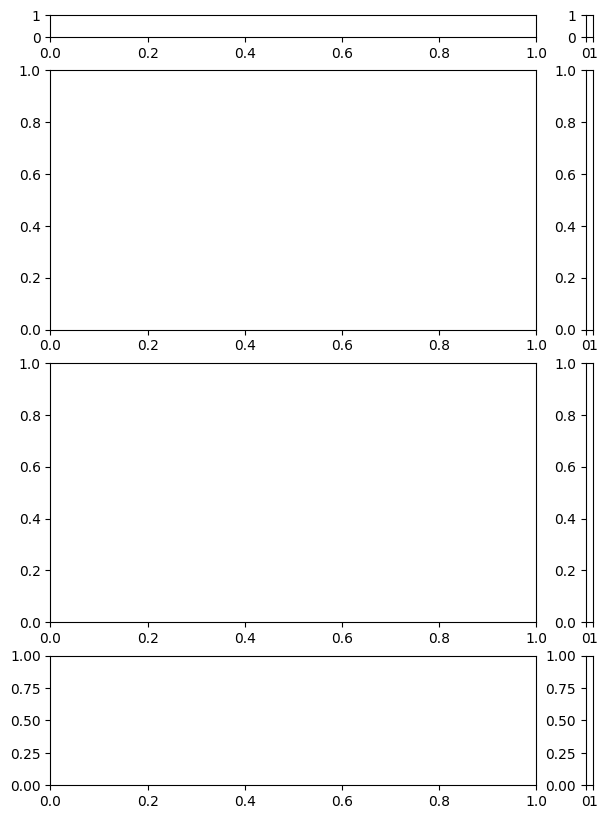

In [38]:
## Plot Pitchgram, liftered pitchgram and CRP 
time_interval = (0,20)
fig,((ax1,ax11),(ax2,ax21),(ax3,ax31),(ax4,ax41)) = plt.subplots(4,2,height_ratios=(.5,6,6,3),
                                                                 width_ratios=(20,.3),figsize=(7,10))
utils.plotChordAnnotations(ax1,gt[0],gt[1],time_interval=time_interval,y_0=0)
ax11.text(0,0.5,"GT")
ax1.set_ylim(0,1.5)
ax11.set_ylim(0,1.5)
ax1.set_yticks([])
# Hide the y-axis line
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.axis("on")
ax11.set_axis_off()
i0,i1 = utils.getTimeIndices(t_chroma,time_interval)
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt[:,i0:i1],ref=np.max(pitchgram_cqt[:,i0:i1])),
                            x_coords=t_chroma[i0:i1],
                            x_axis="time",
                            y_axis='cqt_note',
                            cmap="viridis",
                            fmin=librosa.midi_to_hz(24),
                            bins_per_octave=12,
                            ax=ax2,
                            vmin=-70,
                            vmax=0)
cbar = fig.colorbar(img,cax=ax21)
cbar.ax.set_ylabel("dB", rotation=-90, va="bottom")
img = librosa.display.specshow(pitchgram[:,i0:i1],
                            x_coords=t_chroma[i0:i1],
                            x_axis="time",
                            y_axis='cqt_note',
                            cmap="viridis",
                            fmin=librosa.midi_to_hz(24),
                            bins_per_octave=12,
                            ax=ax3)
ax2.set_ylim(librosa.midi_to_hz(24),librosa.midi_to_hz(104))
ax3.set_ylim(librosa.midi_to_hz(24),librosa.midi_to_hz(104))
cbar = fig.colorbar(img,cax=ax31)
cbar.ax.set_ylabel("linear", rotation=-90, va="bottom")
xticks = np.linspace(time_interval[0],time_interval[1],21)
xticklabels = [xticks[i] if i % 5 == 0 else "" for i in range(21)]
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xticks(xticks)
    ax.set_xlabel("")
    ax.set_xticklabels([])
ax4.set_xticklabels(xticklabels)
ax4.set_xlabel("Time in s")

img = utils.plotChromagram(ax4,t_chroma,chroma,time_interval=time_interval)
fig.colorbar(img,cax=ax41);
fig.tight_layout()
#fig.savefig("../latex/figures/example_two_of_us.png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

def printRow(data,prefilter="RP",alphabet="majmin"):
    text = f"{prefilter} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)


print(f"----------Table of results------------")
rp_text = "RP &"
median_text = "Median &"
header = "prefilter & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    rp, track_list = utils.getFscoreResults("../results/prefilter_rp.hdf5",alphabet,True)
    median,_ = utils.getFscoreResults("../results/prefilter_median.hdf5",alphabet, True)
    printRow(rp,"RP",alphabet)
    printRow(median,"Median",alphabet)
    print("\\midrule")

    # plot paired difference
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        deltas.append([100*(x-y) for x,y in zip(rp[dset],median[dset])])

    # print outliers
    print("-------outliers---------")
    for x,name in zip(deltas[-1],track_list):
        if np.abs(x) > 10:
            print(f"{name} : {x}%")
        
     # plot sorted results
    index = np.argsort(median["combined"])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(100*np.array(median["combined"])[index],'k')
    ax.plot(100*np.array(rp["combined"])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,349)
    ax.set_xlabel("Track number")
    ax.set_ylim(0,100)
    ax.legend(["Median","RP"],loc='lower right')
    fig.savefig(f"../latex/figures/prefilter_sorted_{alphabet}.png")
        
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    # fig.savefig(f"../latex/figures/prefilter_delta_f_{alphabet}.png")
    ax.set_ylabel("delta F-score in %")
    # wilcoxon test
    print("-----Wilcoxon test for paired samples SEVENTHS-------")
    print("dataset & N & z & p & r \\\\")
    print("\\toprule")
    for i,dset in enumerate(["beatles","rwc\_pop","rw","queen","combined"]):
        N,p,z,r = utils.wilcoxonTest(deltas[i])
        if p < 0.001:
            print(f"{dset} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
        else:    
            print(f"{dset} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")


#### Study on Source Separation
Vocals, drums were removed seperately with a hybrid transformer source separation network (demucs) to enhance the chroma.</br>
After seperating the drums, the vocals were again removed from the remaining signal. F-scores for three source separation scenarios were computed (vocals removed, drums removed, vocals and drums removed)



----------Table of results------------
separation & scheme &beatles &rwc\_pop & rw &queen &combined \\
none & majmin &75.00$\pm$14.50 &76.00$\pm$16.00 &76.00$\pm$14.00 &70.50$\pm$17.00 &75.00$\pm$15.00 \\
vocals & majmin &76.00$\pm$13.00 &77.00$\pm$15.25 &78.00$\pm$14.00 &68.50$\pm$17.25 &77.00$\pm$13.00 \\
drums & majmin &75.00$\pm$13.00 &78.00$\pm$14.25 &79.00$\pm$15.00 &73.00$\pm$17.25 &76.00$\pm$14.00 \\
both & majmin &76.00$\pm$12.00 &77.00$\pm$13.00 &79.00$\pm$13.00 &75.50$\pm$19.50 &77.00$\pm$13.00 \\
--------comparison pairs for wilcoxon test----
beatles & none, vocals & 175 & -2.8 & 0.005 & 0.2\\
rwc_pop & none, vocals & 100 & -3.9 & $<$.001 & 0.4\\
rw & none, vocals & 61 & -4.5 & $<$.001 & 0.6\\
queen & none, vocals & 18 & -0.1 & 0.897 & 0.0\\
combined & none, vocals & 354 & -5.8 & $<$.001 & 0.3\\
beatles & none, drums & 175 & -0.0 & 0.969 & 0.0\\
rwc_pop & none, drums & 100 & -5.2 & $<$.001 & 0.5\\
rw & none, drums & 61 & -4.9 & $<$.001 & 0.6\\
queen & none, drums & 18 & -2.

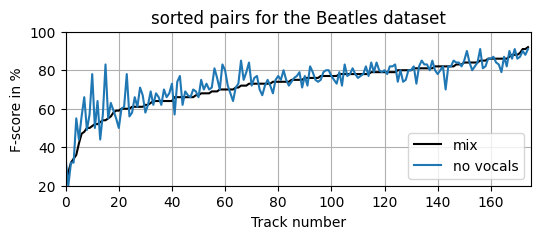

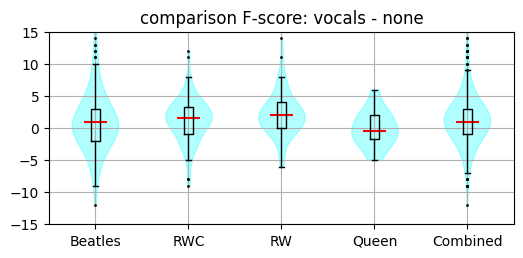

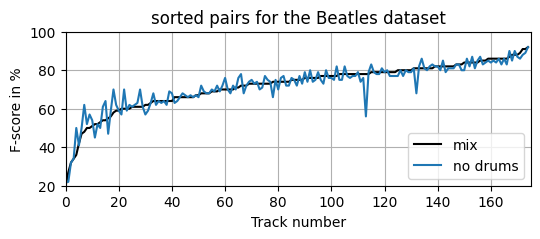

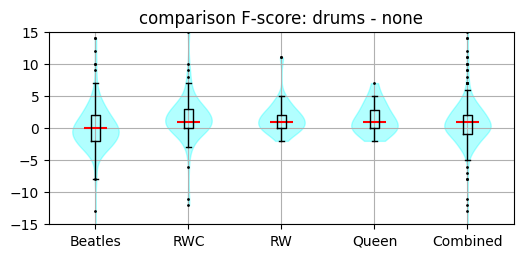

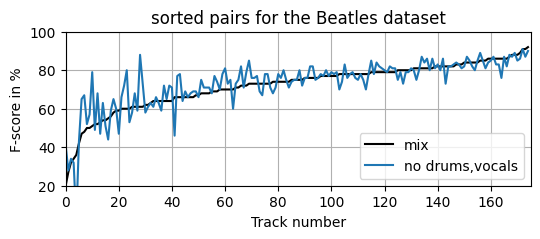

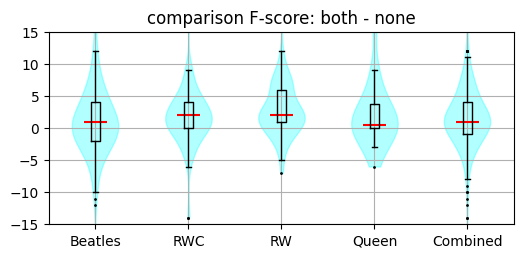

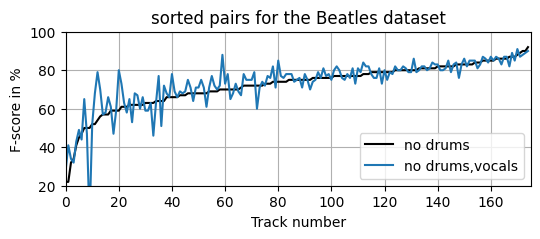

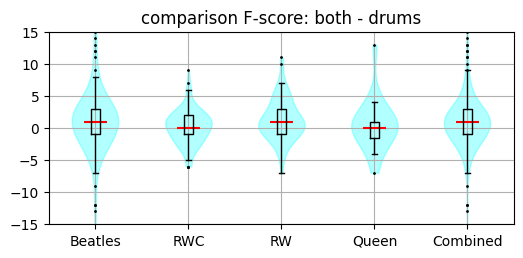

In [ ]:
import h5py
import scipy.stats
import utils
import numpy as np
import matplotlib.pyplot as plt

def getFscoreResults(filepath,alphabet, printMetadata=True):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    f = subgrp.attrs.get(f"{alphabet}_f")
                    f_scores.append(100 * f)
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

def printHeader():
    print(f"----------Table of results------------")
    header = "separation & scheme &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        if dset == "rwc_pop":
            header += "rwc\_pop & "
        else:
            header += dset +" &"
    header = header[:-1] + "\\\\"
    print(header)

def printRowFscore(data,method="none",alphabet="majmin"):
    text = f"{method} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def printRowTtest(data,pair="none"):
    res = scipy.stats.wilcoxon(data,method='approx')
    N = len(data)
    p = res.pvalue
    z = res.zstatistic
    r = np.abs(z) / np.sqrt(N)
    if p < 0.001:
        print(f"{dset} & {pair} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
    else:    
        print(f"{dset} & {pair} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")

printHeader()
data = {}
for separation in ["none","vocals","drums","both"]:
    data[separation] = getFscoreResults(f"../results/source_separation_{separation}.hdf5","majmin",False)
    printRowFscore(data[separation][0],method=separation,alphabet="majmin")

# check if the f-score results are in correct order for all files
for a,b,c,d in zip(data["none"][1],data["vocals"][1],data["drums"][1],data["both"][1]):
    if a != b or b != c or c != d or a != d:
        raise ValueError("filenames don't match!")

print("--------comparison pairs for wilcoxon test----")
# mix,vocals - mix,drums - mix, vocals/drums
outliers = {"vocals":[],"drums":[],"both":[]}
track_list = data["none"][1]
row = "Comparison Pair"
for sep_a,sep_b in zip(["none","none","none","drums"],["vocals","drums","both","both"]):
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [y-x for x,y in zip(data[sep_a][0][dset],data[sep_b][0][dset])]
        printRowTtest(delta,f"{sep_a}, {sep_b}")
        if dset == "combined":
            
            for dF,name in zip(delta,track_list):
                if np.abs(dF) > 10:
                    outliers[sep_b].append((name,dF))
        deltas.append(delta)

    # plot sorted results
    sorted_dset = "beatles"
    index = np.argsort(data[sep_a][0][sorted_dset])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(np.array(data[sep_a][0][sorted_dset])[index],'k')
    ax.plot(np.array(data[sep_b][0][sorted_dset])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,len(data[sep_b][0][sorted_dset]))
    ax.set_xlabel("Track number")
    ax.set_ylim(20,100)
    ax.set_title("sorted pairs for the Beatles dataset")
    if sep_b == "both":   
        text_b = "no drums,vocals"
    else:
        text_b = f"no {sep_b}"
    if sep_a == "drums":
        text_a = f"no drums"
    else:
        text_a = "mix"
    ax.legend([text_a,text_b],loc='lower right')
    # fig.savefig(f"../latex/figures/separation_sorted_{sep_a}_{sep_b}_{sorted_dset}.png")

    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylim(-15,15)
    #fig.savefig(f"../latex/figures/separation_{sep_b}_delta_majmin.png")
    ax.set_title(f"comparison F-score: {sep_b} - {sep_a}")
    fig.savefig(f"../Präsentation/figures/separation_{sep_b}_{sep_a}_delta_majmin.png")

# print outliers
print("-----Outliers----")
for sep in ["vocals","drums","both"]:
    print(sep)
    for (name,dF) in outliers[sep]:
        print(f"  {name} : dF={dF:0.1f}%")


#### Study on correlation vs inner product

----------Table of results------------
distance & scheme &beatles &rwc\_pop & rw &queen &combined \\
correlation & majmin &75.0$\pm$15.5 &75.0$\pm$13.0 &78.0$\pm$16.0 &70.5$\pm$16.5 &76.0$\pm$15.0 \\
inner product & majmin &72.0$\pm$18.5 &71.5$\pm$15.0 &73.0$\pm$19.0 &68.0$\pm$15.8 &72.0$\pm$17.0 \\
\midrule
Wilcoxon Test: combined dataset majmin
N=354 z=-13.3 p=$<$.001  r=0.70\\
correlation & sevenths &67.0$\pm$18.0 &64.5$\pm$22.2 &70.0$\pm$14.0 &62.0$\pm$15.5 &68.0$\pm$18.0 \\
inner product & sevenths &63.0$\pm$20.5 &61.0$\pm$20.2 &67.0$\pm$20.0 &60.5$\pm$17.0 &63.0$\pm$20.0 \\
\midrule
Wilcoxon Test: combined dataset sevenths
N=354 z=-13.2 p=$<$.001  r=0.70\\


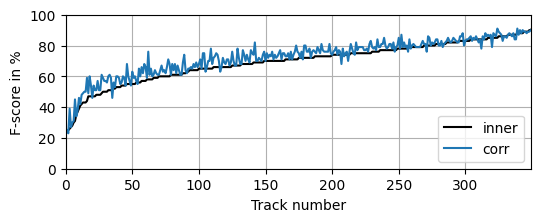

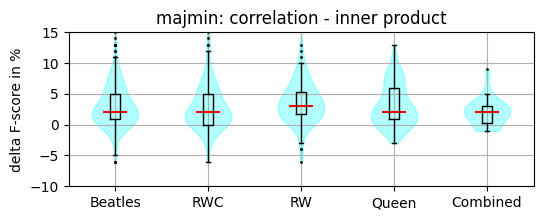

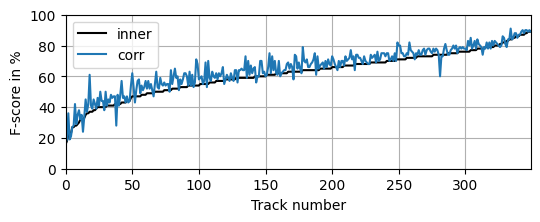

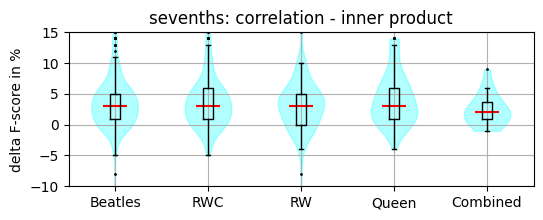

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import utils

def printRow(data,mof="inner",alphabet="majmin"):
    text = f"{mof} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.1f}$\\pm${iqr:0.1f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def getResults(filepath,alphabet="majmin",printMetadata=False):
    results_corr = {"combined":[]}
    results_inner = {"combined":[]}
    results_deltas = {"combined":[]} # correlation - innerproduct
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores_corr = []
            f_scores_inner_product = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    f_scores_corr.append(100 * subgrp.attrs.get(f"{alphabet}_f_correlation"))
                    f_scores_inner_product.append(100 * subgrp.attrs.get(f"{alphabet}_f_inner_product"))
            results_corr[dset] = f_scores_corr
            results_inner[dset] = f_scores_inner_product
            results_deltas[dset] = [x-y for x,y in zip(f_scores_corr,f_scores_inner_product)]
            results_corr["combined"] += f_scores_corr
            results_inner["combined"] += f_scores_inner_product
            results_deltas["combined"] += results_deltas[dset]
    return results_corr,results_inner,results_deltas,track_list

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
print(f"----------Table of results------------")
text = "Median &"
header = "distance & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    results_corr,results_inner,results_deltas,track_list = getResults("../results/distance_measure.hdf5",alphabet,False)
    printRow(results_corr,"correlation",alphabet)
    printRow(results_inner,"inner product",alphabet)
    print("\\midrule")

    # plot sorted results
    index = np.argsort(results_inner["combined"])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(np.array(results_inner["combined"])[index],'k')
    ax.plot(np.array(results_corr["combined"])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,349)
    ax.set_xlabel("Track number")
    ax.set_ylim(0,100)
    ax.legend(["inner","corr"])
    # fig.savefig(f"../latex/figures/corr_sorted_{alphabet}.png")

    # plot deltas
    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,[x for x in results_deltas.values()],xlabels)
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/corr_delta_{alphabet}.png")
    ax.set_title(f"{alphabet}: correlation - inner product")
    ax.set_ylim(-10,15)
    fig.savefig(f"../Präsentation/figures/corr_delta_{alphabet}.png")
    print(f"Wilcoxon Test: combined dataset {alphabet}")
    (N,p,z,r) = utils.wilcoxonTest(results_deltas["combined"])
    if p < 0.001:
        print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
    else:    
        print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")

#### Comparison of Chord Models

In [39]:
import matplotlib.pyplot as plt
import h5py
import utils
# est_cpss_majmin_f, stable_cpss_majmin_f
# est_templates_majmin_f, stable_templates_majmin_f

def getFscoreResults(filepath, model, alphabet, printMetadata=True):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    if file.attrs.get("experiment") == "pitchspace_crp": 
                        f = subgrp.attrs.get(f"{alphabet}_f_{model}")
                    else:
                        f = subgrp.attrs.get(f"{model}_{alphabet}_f")
                    if f is None: # deep chroma estimation is stored in different format!
                        f = subgrp.attrs.get(f"{alphabet}_f")
                    f_scores.append(100 * f)
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

def printRow(data,model="inner",alphabet="majmin"):
    text = f"{model} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.1f}$\\pm${iqr:0.1f} &"
    text = text[:-1]+ "\\\\"
    print(text)

# Comparison of Template and CPSS model with the CRP feature
data = {}
# load transcription results for total transcription, and for stable chroma regions
for model in ["cpss","templates","stableregions_cpss","stableregions_templates"]:
    for alphabet in ["majmin","sevenths"]:
        data[f"{model}_{alphabet}"] = getFscoreResults("../results/crp_pitchspace.hdf5",model,alphabet,False)
print(f"----------Table of results------------")
header = "model & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    printRow(data[f"templates_{alphabet}"][0],"Templates",alphabet)
    printRow(data[f"cpss_{alphabet}"][0],"CPSS",alphabet)
    print("\\midrule")
print("----------------------------")

# plot deltas in stable regions
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"stableregions_cpss_{alphabet}"][0][dset],
                                    data[f"stableregions_templates_{alphabet}"][0][dset])]
        deltas.append(delta)
        if dset == "combined":
            print(f"Wilcoxon Test stable regions: combined dataset {alphabet}")
            (N,p,z,r) = utils.wilcoxonTest(delta)
            if p < 0.001:
                print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
            else:    
                print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")

    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/crp_delta_stableregions_{alphabet}.png")
    plt.close()

    
# difference of models
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"cpss_{alphabet}"][0][dset],
                                    data[f"templates_{alphabet}"][0][dset])]
        deltas.append(delta)        
        if dset == "combined":
            print(f"Wilcoxon Test stable regions: combined dataset {alphabet}")
            (N,p,z,r) = utils.wilcoxonTest(delta)
            if p < 0.001:
                print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
            else:    
                print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")
    # plot paired difference
   
    if dset == "combined": 
        print("-------outliers---------")
        for x,name in zip(deltas[-1],data[f"templates_{alphabet}"][1]):
            if x > 10:
                print(f"{name} : {x:0.2f}%")
    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/crp_delta_{alphabet}.png")
    plt.close()

----------Table of results------------
model & scheme &beatles &rwc\_pop & rw &queen &combined \\
Templates & majmin &79.3$\pm$13.6 &80.5$\pm$13.4 &81.8$\pm$16.6 &73.8$\pm$18.0 &79.6$\pm$13.8 \\
CPSS & majmin &74.5$\pm$12.1 &77.0$\pm$13.2 &77.4$\pm$11.1 &71.9$\pm$17.7 &75.7$\pm$12.7 \\
\midrule
Templates & sevenths &72.6$\pm$18.2 &68.8$\pm$24.1 &77.9$\pm$15.8 &67.1$\pm$21.9 &72.1$\pm$19.1 \\
CPSS & sevenths &67.6$\pm$14.0 &67.8$\pm$17.9 &71.4$\pm$14.9 &66.6$\pm$17.9 &68.5$\pm$15.3 \\
\midrule
----------------------------
Wilcoxon Test stable regions: combined dataset majmin
N=354 z=-12.5 p=$<$.001  r=0.66\\
Wilcoxon Test stable regions: combined dataset sevenths
N=354 z=-12.8 p=$<$.001  r=0.68\\
Wilcoxon Test stable regions: combined dataset majmin
N=354 z=-9.5 p=$<$.001  r=0.50\\
-------outliers---------
CD1_-_02_-_Dear_Prudence : 24.81%
08_-_I've_Got_A_Feeling : 13.85%
DREAM MAGIC : 17.80%
Killing Me : 12.55%
Wilcoxon Test stable regions: combined dataset sevenths
N=354 z=-9.3 p=$<$.

----------Table of results------------
model & scheme &beatles &rwc\_pop & rw &queen &combined \\
DCP & majmin &85.0$\pm$9.0 &84.5$\pm$9.0 &86.0$\pm$11.0 &80.5$\pm$21.2 &85.0$\pm$10.0 \\
Templates & majmin &83.0$\pm$10.2 &82.0$\pm$10.0 &86.0$\pm$12.0 &79.0$\pm$18.0 &83.0$\pm$11.0 \\
CPSS & majmin &80.0$\pm$11.0 &79.0$\pm$10.0 &81.0$\pm$14.0 &75.5$\pm$17.5 &80.0$\pm$11.0 \\
\midrule
DCP & sevenths &80.0$\pm$16.0 &71.0$\pm$27.2 &83.0$\pm$14.0 &73.0$\pm$19.5 &79.0$\pm$17.0 \\
Templates & sevenths &79.5$\pm$17.2 &68.0$\pm$28.0 &83.0$\pm$15.0 &70.0$\pm$22.5 &77.0$\pm$19.0 \\
CPSS & sevenths &76.0$\pm$18.0 &70.5$\pm$17.5 &78.0$\pm$15.0 &69.0$\pm$15.8 &74.0$\pm$18.0 \\
\midrule
----------------------------
Wilcoxon Test stable regions: combined dataset majmin
N=354 z=-13.2 p=$<$.001  r=0.70\\
Wilcoxon Test stable regions: combined dataset sevenths
N=354 z=-13.2 p=$<$.001  r=0.70\\
Wilcoxon Test stable regions: TEMPLATES DCP combined dataset majmin
N=349 z=-7.3 p=$<$.001  r=0.39\\
Wilcoxon Tes

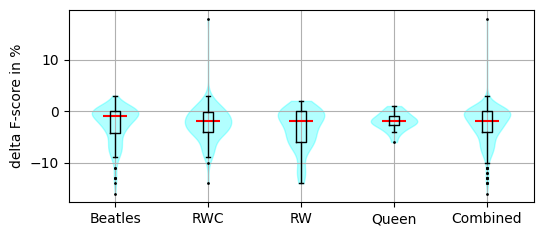

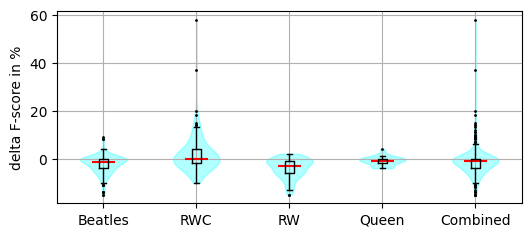

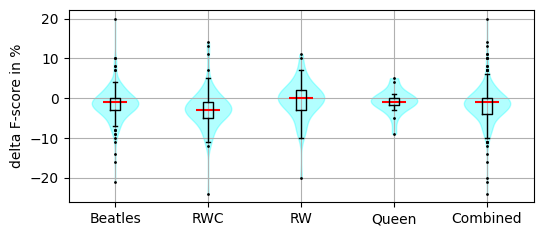

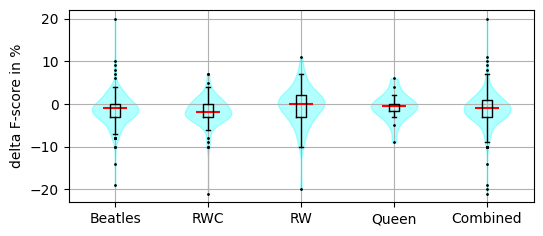

In [40]:
data = {}
# load transcription results for total transcription, and for stable chroma regions
for model in ["est_cpss","est_templates","stable_cpss","stable_templates"]:
    for alphabet in ["majmin","sevenths"]:
        data[f"{model}_{alphabet}"] = getFscoreResults("../results/dcp_pitchspace.hdf5",model,alphabet,False)

# load transcription results with deep chroma processor
for alphabet in ["majmin","sevenths"]:
    data[f"est_dcp_{alphabet}"] = getFscoreResults("../results/dcp_madmom.hdf5",model,alphabet,False)

# check if the f-score results are in correct order for both files!
for a,b in zip(data["est_dcp_majmin"][1],data["est_cpss_majmin"][1]):
    if a != b:
        raise ValueError("filenames don't match!")

# plot table of Transcription results
colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
print(f"----------Table of results------------")
header = "model & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    printRow(data[f"est_dcp_{alphabet}"][0],"DCP",alphabet)
    printRow(data[f"est_templates_{alphabet}"][0],"Templates",alphabet)
    printRow(data[f"est_cpss_{alphabet}"][0],"CPSS",alphabet)
    print("\\midrule")
print("----------------------------")
# plot deltas in stable regions
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"stable_cpss_{alphabet}"][0][dset],
                                    data[f"stable_templates_{alphabet}"][0][dset])]
        deltas.append(delta)
        if dset == "combined":
            print(f"Wilcoxon Test stable regions: combined dataset {alphabet}")
            (N,p,z,r) = utils.wilcoxonTest(results_deltas["combined"])
            if p < 0.001:
                print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
            else:    
                print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    plt.close()
    # fig.savefig(f"../latex/figures/stable_regions_{alphabet}.png")

# pairwise comparison of models
    
# CPSS vs Templates
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"est_cpss_{alphabet}"][0][dset],
                                    data[f"est_templates_{alphabet}"][0][dset])]
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/comparison_cpss_templates_{alphabet}.png")
    plt.close()

# Templates vs DCP
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"est_templates_{alphabet}"][0][dset],
                                    data[f"est_dcp_{alphabet}"][0][dset])]
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/comparison_templates_dcp_{alphabet}.png")
    if dset == "combined":
        print(f"Wilcoxon Test stable regions: TEMPLATES DCP combined dataset {alphabet}")
        (N,p,z,r) = utils.wilcoxonTest(delta)
        if p < 0.001:
            print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
        else:    
            print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")

# CPSS vs DCP
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"est_cpss_{alphabet}"][0][dset],
                                    data[f"est_dcp_{alphabet}"][0][dset])]
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/comparison_cpss_dcp_{alphabet}.png")
    plt.close()


#### Visualization Tool

In [ ]:
from visualization import visualizationApp
import matplotlib.pyplot as plt
%matplotlib inline
visualizationApp("../results")
plt.ioff();